Current runtime: ~1.5min

# Working with Chlorophyll Data from the Cloud

Developed during [OceanHackWeek 2019](https://oceanhackweek.github.io) by [Ben Storer](https://github.com/bastorer), [Melanie Feen](https://github.com/melaniefeen), and [Chelle Gentemann](https://github.com/cgentemann).

This notebook illustrates how to remotely access chlorophyll data from *OceanData.sci*.

In particular, it allows the user to specify
* time range of interest
* variable of interest
* time binning method (daily or 8-day means)
* spatial resolution (4km or 9km)

The data is loaded lazily into xarray. This means that data is only transferred to the local machine when it is need, which reduces memory requirements, but does of course mean that thing will take a bit longer.

#### Other notebooks

* [This notebook](CHL_dap_trim_read.ipynb) allows you to subset the data *before* doing any operations. This allows the user to consider a larger time region without encurring the same computational cost.
* [This notebook](CHL_SST_gradients.ipynb) works through loading chlorophyll as seas-surface temperature data and then computes spatial gradients.
* [This notebook](../Collocation/Match_InSitu.ipynb) compares the kind of chlorophyll data loaded here with similiar data from Saildrones.

### To begin, load in our packages of choice

In [1]:
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cmocean
from pyproj import Proj

from AddParallels_and_Meridians import AddParallels_and_Meridians

#### This is only if you use a dark background notebook. Otherwise, comment this out.

In [2]:
plt.style.use('dark_background')

font = {'size' : 16}

matplotlib.rc('font', **font)

## Specify Data Selection

* `start_date`: datetime object indicating beginning time for selection. In `'YYYY-MM-DD'` format.
* `end_date`: datetime object indicating end time (none-inclusive) for selection. In `'YYYY-MM-DD'` format.
* `VAR`: desired variable. Currently only tested for `'CHL'`
* `ALG`: associated variable algorithm/method. Currently only tested for `'chl_ocx'`
* `BIN`: time-binning period. Currently only accepts `'DAY'` and `'8D'` for dail and 8-day averages, respectively
* `SRES`: spatial resolution. Options are `'4km'` and `'9km'`

In [3]:
## YYYY-MM-DD
start_date = np.datetime64('2018-01-01')
end_date   = np.datetime64('2018-07-01')
num_days = (end_date - start_date).tolist().days

# variable to load
VAR = 'CHL'

# algorithm
ALG = 'chl_ocx'

# Binning period
BIN = '8D'  # DAY, 8D

# Spatial resolution
SRES = '9km'   # 4km, 9km

## Create a list of URLs and associated times

These URLs will then be used to access the requested netcdf datafiles.

In [4]:
# Build a list of URLs and datetime objects
dap_urls = []
the_days = []

# The base url, which needs a tail piece to points to the specific data file.
url_base = "https://oceandata.sci.gsfc.nasa.gov:443/opendap/MODISA/L3SMI/"

for ii in range(num_days):
    
    # Determine current date
    curr_date = start_date + ii
    
    curr_year = curr_date.tolist().year
    ref_date = np.datetime64('{0:d}-01-01'.format(curr_year))
    
    day_num = 1 + (curr_date - ref_date).tolist().days
    
    # We need to change the formatting a bit depending on the binning
    do = True
    if BIN == 'DAY':
        # If we're on daily data, time_str is 'AYYYYDDD'
        time_str = 'A{0:d}{1:03d}'.format(curr_year, day_num)
    elif BIN == '8D':
        # If we're on 8-day data, time_str is 'AYYYYDDDYYYYDDD'
        #    where the first YYYYDDD is the start of the averaging
        #    period, and the second is the end of the period.
        if (day_num - 1) % 8 == 0:
            targ_day = day_num + 7
            if targ_day > 365:
                targ_day = 365
            
            time_str = 'A{0:d}{1:03d}{2:d}{3:03d}'.format(curr_year, day_num, curr_year, targ_day)
        else:
            # There isn't an 8D set starting here
            do = False
    
    # Now build the actual URL.
    if do:
        file_url = url_base + \
                '{0:d}/{1:03d}/{2}'.format(curr_year, day_num, time_str) + \
                '.L3m_{0}_{1}_{2}_{3}'.format(BIN, VAR, ALG, SRES) + \
                '.nc'
    
        dap_urls += [file_url]
        the_days += [curr_date]
    
print('dap_urls containts {0:d} urls for {1} data.'.format(len(dap_urls), VAR))

dap_urls containts 23 urls for CHL data.


## Now load the datasets

We don't use `xr.open_mfdataset` because the source datafiles have no time dimension, in addition to having some extraneous variables the cause merging problems.

Instead, we simply create a list of datasets, on for each URL, and in the same order as the URLs.

In [5]:
data_sets = [xr.open_dataset(url) \
             for (url,ind) \
             in zip(dap_urls, np.arange(num_days))]

### Create the time array corresponding to the datasets

In [6]:
time_array = xr.DataArray(the_days, None, 'time', 'time')

### Concatenate each separate dataset into one large dataset with a time dimension. 

The values of the time dimension will be taken from `time_array`.

In [7]:
merged = xr.concat(data_sets, time_array)

## Analysis

We now have the desired dataset 'loaded' into our notebook (recall that it is lazy loading). We can now proceed to analyze the data as we desire!

##### Time-Longitude Mean

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'Time and Longitude Mean of Chlorophyll')

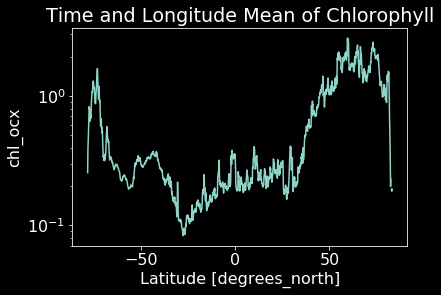

In [8]:
merged.chl_ocx.mean(dim=['time', 'lon']).plot()
plt.gca().set_yscale('log')
plt.gca().set_title('Time and Longitude Mean of Chlorophyll')

##### Latitude-Longitude Mean

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


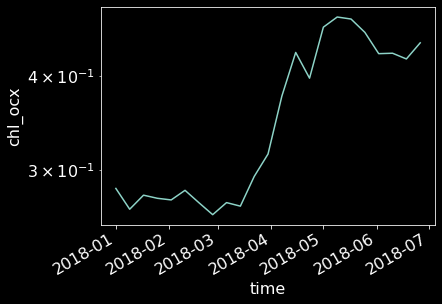

In [9]:
merged.chl_ocx.mean(dim=['lat', 'lon']).plot()
plt.gca().set_yscale('log')

##### Time-Mean

###### Subsetting

Plotting the whole globe takes a while, so let's just plot a small regiong

In [10]:
lon_lb = -125
lon_ub = - 35

lat_lb = -20
lat_ub =  70

subs_mean_chl = merged.chl_ocx.sel(lon=slice(lon_lb,lon_ub),lat=slice(lat_ub,lat_lb)).mean(dim='time').data
subs_std_chl  = merged.chl_ocx.sel(lon=slice(lon_lb,lon_ub),lat=slice(lat_ub,lat_lb)).std(dim='time').data

subs_lon = merged.lon.sel(lon=slice(lon_lb,lon_ub)).data
subs_lat = merged.lat.sel(lat=slice(lat_ub,lat_lb)).data

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


###### Specify some lat/lon lines to plot

In [11]:
meridians = np.round(np.linspace(subs_lon.min(), subs_lon.max(), 5))
parallels = np.round(np.linspace(subs_lat.min(), subs_lat.max(), 5))

###### Create map projection

In [12]:
proj = Proj(proj='wag7', lon_0=subs_lon.mean(), lat_0=subs_lat.mean())

###### Project our grid

In [13]:
sLON, sLAT = np.meshgrid(subs_lon, subs_lat)

Xp, Yp = proj(sLON, sLAT, inverse=False)

##### Plotting!

/srv/conda/envs/notebook/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


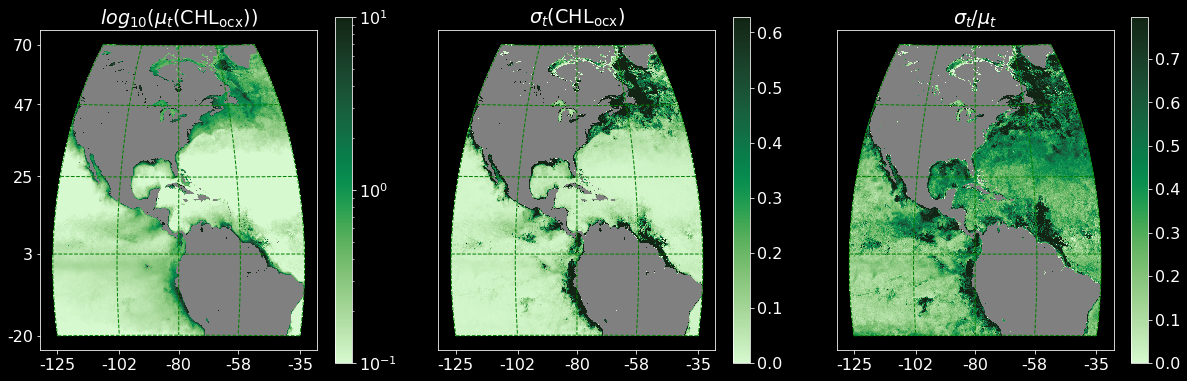

In [14]:
gridspec_props = dict(wspace = 0.15, hspace = 0.15, left = 0.1, right = 0.95, bottom = 0.1, top = 0.9)

rat   = (Xp.max() - Xp.min()) / (Yp.max() - Yp.min())
rat  *= (3./1) * (1.2)
fig_h = 6.

cmap = plt.get_cmap('cmo.algae')
cmap.set_bad('gray', 1.)

fig, axes = plt.subplots(1, 3, sharex=True, figsize=(fig_h*rat, fig_h), gridspec_kw = gridspec_props)

q0 = axes[0].pcolormesh(Xp, Yp, subs_mean_chl, norm=colors.LogNorm(vmin=1e-1, vmax=1e1), cmap=cmap)

to_plot = subs_std_chl
cv = np.nanpercentile(to_plot, 90)
q1 = axes[1].pcolormesh(Xp, Yp, to_plot, vmin=0, vmax=cv, cmap=cmap)

to_plot = subs_std_chl / (subs_mean_chl + 1e-5)
cv = np.nanpercentile(to_plot, 90)
q2 = axes[2].pcolormesh(Xp, Yp, to_plot, vmin=0, vmax=cv, cmap=cmap)

plt.colorbar(q0, ax=axes[0])
plt.colorbar(q1, ax=axes[1])
plt.colorbar(q2, ax=axes[2])

axes[0].set_title('$log_{10}(\mu_t(\mathrm{CHL}_{\mathrm{ocx}}))$')
axes[1].set_title('$\sigma_t(\mathrm{CHL}_{\mathrm{ocx}})$')
axes[2].set_title('$\sigma_t / \mu_t$')

for ax in axes:
    AddParallels_and_Meridians(ax, proj, parallels, meridians, subs_lat, subs_lon)
    ax.set_aspect('equal')
    
for ax in axes[1:]:
    ax.set_yticks([])